In [492]:
import os
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import geopandas as gp

In [430]:
# Read in the CSVs from the data folder

# find files
data_dir = "../data"
files = [os.path.join(data_dir,x) for x in os.listdir("../data")]

# read as dataframes
p = pd.read_csv(files[0])
q = pd.read_csv(files[1])
et = pd.read_csv(files[2])
ds = pd.read_csv(files[3], sep='\t', header=0)

# set indices as time
p.set_index(p.columns[0], inplace=True)
q.set_index(q.columns[0], inplace = True)
et.set_index(et.columns[0], inplace = True)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)
p.index = pd.to_datetime(p.index)
q.index = pd.to_datetime(q.index)
et.index = pd.to_datetime(et.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)

# Merge the dfs
p_q = pd.merge(p,q, left_index=True, right_index=True)
p_q_et = pd.merge(p_q, et, left_index=True, right_index=True)

# Set the timezones to none
p_q_et = p_q_et.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(p_q_et, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [431]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et'] = df.modis*study_area * 1e-3 # multiply by study area and convert mm to m
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [432]:
df['ds'] = df.p - df.et - df.q

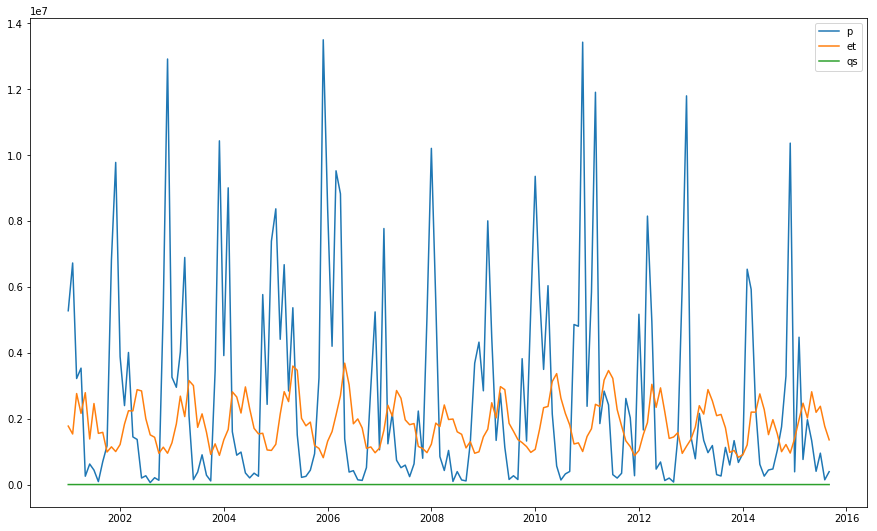

In [467]:
plt.figure(figsize = (15, 9))

plt.plot(df.index,df['prism'], label = "p")
plt.plot(df.index,df['modis'], label = "et")
plt.plot(df.index,df['discharge_cms'], label = "qs")

plt.legend()
plt.show()

In [570]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year+1)

sums = {}

for year in years:
    ds = df[df.index.year == year]
    ds_year = np.sum(ds['ds'])
    sums[year] = ds_year

In [626]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame(sums.values(), index = dt_idx)
ds_df.columns = ['ds']

window = 3
ds_df['smooth'] = ds_df.rolling(window, win_type='triang').mean()

In [627]:
from sklearn.preprocessing import MinMaxScaler

mms = preprocessing.MinMaxScaler()

scaled = []

for i in [ds_df.ds,ds_df.smooth,df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


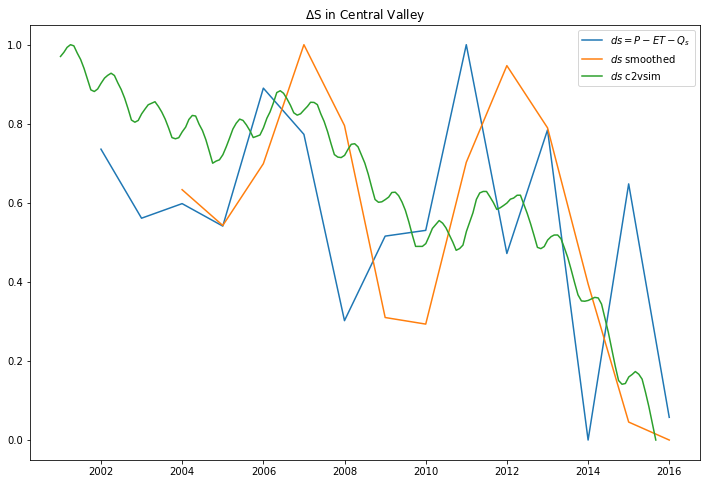

In [629]:
plt.figure(figsize=(12,8))

plt.title("$\Delta$S in Central Valley")
plt.plot(ds_df.index, scaled[0], label = "$ds = P - ET - Q_s$")
plt.plot(ds_df.index[window-1:], scaled[1], label = '$ds$ smoothed')
plt.plot(df.index, scaled[2], label = "$ds$ c2vsim")
plt.legend()

plt.show()

In [575]:
years = np.arange(df.index[0].year, df.index[-1].year+1)

In [576]:
sums1 = {}

for year in years:
    ds = df[df.index.year == year]
    ds_year = np.sum(ds['ds'])
    sums[year] = ds_year

In [577]:
sums2 = {}

for year in years:
    ds = df[df.index.year == year]
    ds_year = np.sum(ds['ds'])
    sums[year] = ds_year

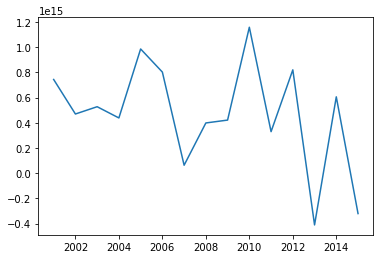

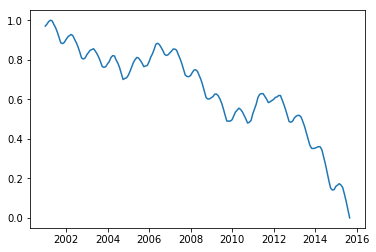

In [578]:
plt.plot(sums.keys(),sums.values())
plt.show()
plt.plot(dt, ds1)
plt.show()

In [579]:
# 3 year rolling mean
d = pd.Series(np.array(list(sums.values())).astype(float))

window = 4
means = d.rolling(window, win_type='boxcar').mean()

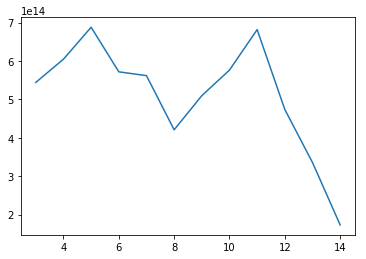

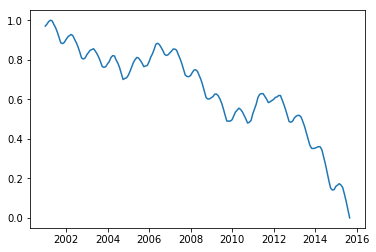

In [580]:
plt.plot(means)
plt.show()
plt.plot(dt, ds1)
plt.show()

In [581]:
window

4

In [582]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame(sums.values(), index = dt_idx)
ds_df.columns = ['ds']

In [618]:
window = 4
ds_df['smooth'] = ds_df.rolling(window, win_type='boxcar').mean()

In [619]:
from sklearn.preprocessing import MinMaxScaler

mms = preprocessing.MinMaxScaler()

scaled = []

for i in [ds_df.ds,ds_df.smooth,df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


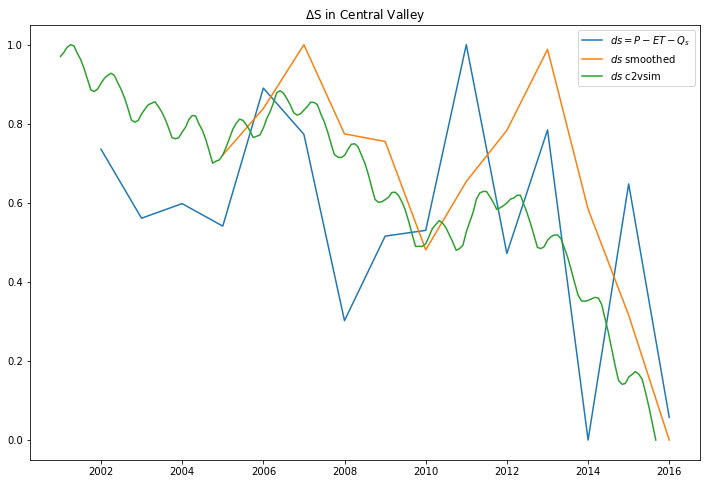

In [624]:
plt.figure(figsize=(12,8))

plt.title("$\Delta$S in Central Valley")
plt.plot(ds_df.index,scaled[0], label = "$ds = P - ET - Q_s$")
plt.plot(ds_df.index[window-1:],scaled[1], label = '$ds$ smoothed')
plt.plot(df.index, scaled[2], label = "$ds$ c2vsim")
plt.legend()